## Notebook to check to which cluster each point of the two 15years is associated

Now that I have found the centroids over the 30-year period, I check to which centroid each point from the two 15-year periods is assigned.

This allows me to compare how the frequency and nature of atmospheric regimes change between the two periods using a common basis (the global centroids).

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import xarray as xr
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import shapefile as shp
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.spatial.distance import cdist
import joblib
import importlib
import utils.data_processing
import utils.visualization
importlib.reload(utils.data_processing)
importlib.reload(utils.visualization)

# Import the functions 
from utils.data_processing import prepare_data_matrix

In [ ]:

global_mean = np.load("global_mean_30y.npy")
global_std = np.load("global_std_30y.npy")
centroids = np.load("centroids_k23_30y.npy")   ### CHANGE WHEN CHANGING K

In [ ]:
# Second 15 years
ds = xr.open_dataset('../era5_2009_2023.grib', engine='cfgrib')   ### CHANGE WHEN CHANGING FILE

ds_filtered = xr.Dataset()
#
z_500 = ds['z'].sel(isobaricInhPa=[500])
t_850 = ds['t'].sel(isobaricInhPa=[850])
# Rename the coordinates in order to avoid conflicts
z_500 = z_500.rename({'isobaricInhPa': 'pressure_z'})
t_850 = t_850.rename({'isobaricInhPa': 'pressure_t'})
# Combine everything into the filtered dataset
ds_filtered = xr.Dataset({
    'z': z_500,
    't': t_850
})

dates_late = pd.to_datetime(ds_filtered.time.values)    ### CHANGE WHEN CHANGING FILE
np.save("dates_2009_2023.npy", dates_late)              ### CHANGE WHEN CHANGING FILE

# Prepare the matrix
X_1_matrix, _ = prepare_data_matrix(ds_filtered) 

del ds, #ds_filtered
gc.collect()


Processing z...
     → z: ('time', 'pressure_z', 'latitude', 'longitude') → (5478, 64521)
Processing t...
     → t: ('time', 'pressure_t', 'latitude', 'longitude') → (5478, 64521)

Combined matrix shape: (5478, 129042)


0

In [4]:
print("X_1_matrix shape:", X_1_matrix.shape)
print("global_mean shape:", global_mean.shape)
print("global_std shape:", global_std.shape)

X_1_matrix shape: (5478, 129042)
global_mean shape: ()
global_std shape: ()


In [ ]:
# Standardize the data using the global mean and std
X_1_std = (X_1_matrix - global_mean) / global_std
X_1_std = X_1_std.astype(np.float32)

del X_1_matrix
gc.collect()

0

In [ ]:
# Load the fitted IPCA model
ipca = joblib.load("ipca_30y.pkl")
print("X_1_std shape:", X_1_std.shape)
print("ipca n_features_in_:", ipca.n_features_in_)

X_1_std shape: (5478, 129042)
ipca n_features_in_: 129042


In [ ]:
# Apply PCA
X_1_pca = ipca.transform(X_1_std)

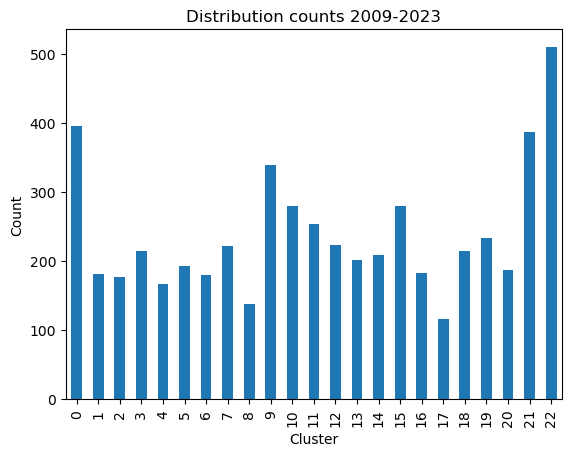

In [ ]:
# Assign clusters based on the centroids
distances = cdist(X_1_pca, centroids)
labels_1 = np.argmin(distances, axis=1)
np.save("labels_2009_2023.npy", labels_1)        ### CHANGE WHEN CHANGING FILE

# Plot counts
pd.Series(labels_1).value_counts().sort_index().plot(kind='bar')
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Distribution counts 2009-2023")    ### CHANGE WHEN CHANGING FILE
plt.show()

# Plot monthly distribution of clusters
months = pd.to_datetime(ds_filtered.time.values).month
df = pd.DataFrame({'cluster': labels_1, 'month': months})
pivot = pd.crosstab(df['month'], df['cluster'])
pivot.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10,5))
plt.xlabel("Month")
plt.ylabel("Number of days")
plt.title("Monthly distribution of clusters (2009-2023)")    ### CHANGE WHEN CHANGING FILE
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

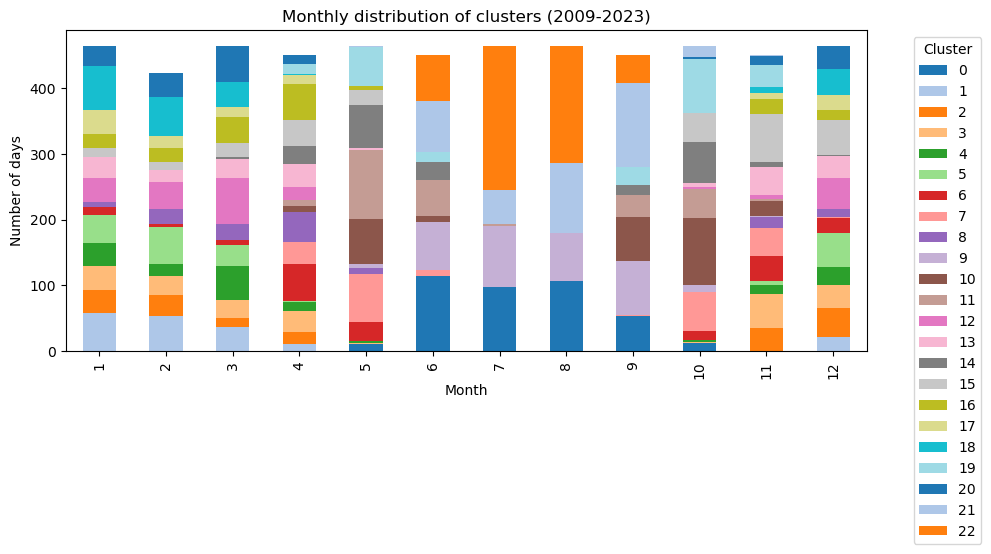

In [ ]:
# Plot monthly distribution of clusters
months = pd.to_datetime(ds_filtered.time.values).month
df = pd.DataFrame({'cluster': labels_1, 'month': months})
pivot = pd.crosstab(df['month'], df['cluster'])

n_clusters = len(pivot.columns) - 2 if 'month' in pivot.columns and 'period' in pivot.columns else len(pivot.columns)
colors = plt.get_cmap('tab20').colors[:n_clusters]

ax = pivot.plot(kind='bar', stacked=True, color=colors, figsize=(10,5))
plt.xlabel("Month")
plt.ylabel("Number of days")
plt.title("Monthly distribution of clusters (2009-2023)")           #### CHANGE WHEN CHANGING FILE
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Analysis and comparing between the two periods

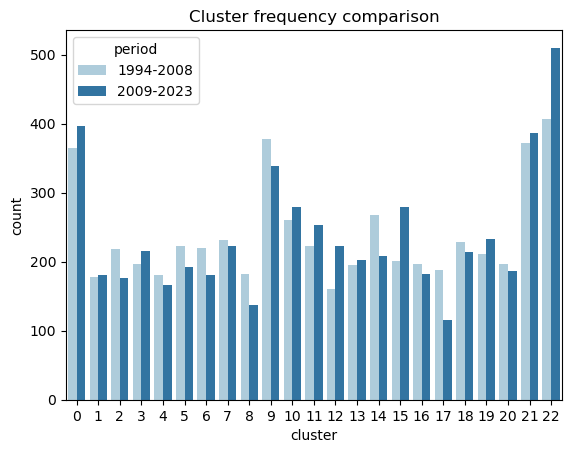

In [ ]:
# Comparison plot
labels_early = np.load("labels_1994_2008.npy") # labels for 1994-2008
labels_late = np.load("labels_2009_2023.npy")  # labels for 2009-2023

df = pd.DataFrame({
    'period': ['1994-2008']*len(labels_early) + ['2009-2023']*len(labels_late),
    'cluster': np.concatenate([labels_early, labels_late])
})
sns.countplot(data=df, x='cluster', hue='period', palette="Paired")
plt.title("Cluster frequency comparison")
plt.show()

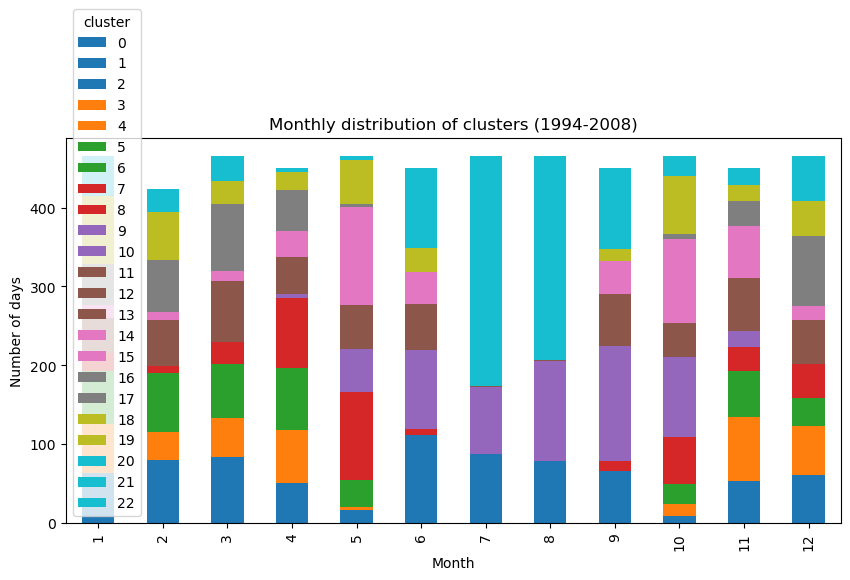

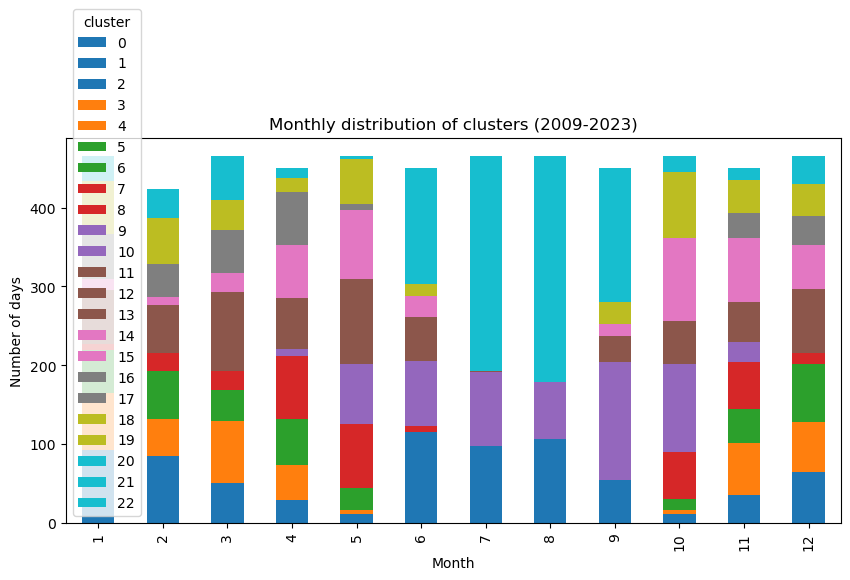

In [ ]:
##### redundant with above #####
dates_early = pd.to_datetime(np.load("dates_1994_2008.npy"))
dates_late = pd.to_datetime(np.load("dates_2009_2023.npy"))

# Create DataFrame for each period
df_early = pd.DataFrame({'month': dates_early.month, 'cluster': labels_early, 'period': '1994-2008'})
df_late = pd.DataFrame({'month': dates_late.month, 'cluster': labels_late, 'period': '2009-2023'})

# Unify the two DataFrame
df_all = pd.concat([df_early, df_late])

# Tabella di contingenza: mesi vs cluster per ciascun periodo
pivot = pd.crosstab([df_all['month'], df_all['period']], df_all['cluster'])

# Plot monthly distribution of clusters for each period
pivot = pivot.reset_index()
for period in ['1994-2008', '2009-2023']:
    subset = pivot[pivot['period'] == period].set_index('month')
    subset.drop('period', axis=1, inplace=True)
    subset.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10,5))
    plt.title(f"Monthly distribution of clusters ({period})")
    plt.xlabel("Month")
    plt.ylabel("Number of days")
    plt.show()